# Import Libraries

In [182]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import os
import splitfolders
import numpy as np
from keras import models, layers
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from keras import optimizers, losses
import numpy as np

# Obtain & Pre-Process Data

Perform train test split on image folders for each class

In [2]:
input_folder = 'Data/class_data'
output_folder = 'Data/ttsplit_data'
classes = ['paper', 'rock', 'scissors']

splitfolders.ratio(input_folder, output=output_folder, seed=37, ratio=(.64, .2, .16))

# train val test

Copying files: 2188 files [00:05, 369.07 files/s]


Determine batch size of images from all 3 classes

In [74]:
train_folder = 'Data/ttsplit_data/train'
test_folder = 'Data/ttsplit_data/test'
val_folder = 'Data/ttsplit_data/val'
classes = ['paper', 'rock', 'scissors']

train_imgs = []
test_imgs = []
val_imgs = []

for img_class in classes:
    train_imgs.extend([file for file in os.listdir(train_folder+'/'+img_class) if file.endswith('.png')])
    test_imgs.extend([file for file in os.listdir(test_folder+'/'+img_class) if file.endswith('.png')])
    val_imgs.extend([file for file in os.listdir(val_folder+'/'+img_class) if file.endswith('.png')])
    
train_batch_size = len(train_imgs)
test_batch_size = len(test_imgs)
val_batch_size = len(val_imgs)

print(train_batch_size)
print(test_batch_size)
print(val_batch_size)

1399
352
437


Generate data from the images

In [75]:
train_generator = ImageDataGenerator().flow_from_directory(
                        output_folder+'/train', target_size=(300, 200), batch_size = train_batch_size)

test_generator = ImageDataGenerator().flow_from_directory(
                        output_folder+'/test', target_size=(300, 200), batch_size = test_batch_size) 

val_generator = ImageDataGenerator().flow_from_directory(
                        output_folder+'/val', target_size=(300, 200), batch_size = val_batch_size) 

Found 1399 images belonging to 3 classes.
Found 352 images belonging to 3 classes.
Found 437 images belonging to 3 classes.


Split image data into image and label variables

In [76]:
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

# Explore Data

Calculate the shape of image data

In [38]:
print('Train images shape: ', train_images.shape)
print('Test images shape: ', test_images.shape)
print('Val images shape: ', val_images.shape)

Train images shape:  (1399, 300, 200, 3)
Test images shape:  (352, 300, 200, 3)
Val images shape:  (437, 300, 200, 3)


Calculate shape of label data

In [39]:
print('Train labels shape: ', train_labels.shape)
print('Test labels shape: ', test_labels.shape)
print('Val labels shape: ', val_labels.shape)

Train labels shape:  (1399, 3)
Test labels shape:  (352, 3)
Val labels shape:  (437, 3)


Calculate label class distribution

In [40]:
train_labels_df = pd.DataFrame(train_labels)
test_labels_df = pd.DataFrame(test_labels)
val_labels_df = pd.DataFrame(val_labels)
total_labels_df = pd.concat([train_labels_df, test_labels_df, val_labels_df], axis=0)


print('Train set class distribution')
print(train_labels_df.mean())

print('Test set class distribution')
print(test_labels_df.mean())

print('Val set class distribution')
print(val_labels_df.mean())

print('Overall class distribution')
print(total_labels_df.mean())

Train set class distribution
0    0.325232
1    0.331665
2    0.343102
dtype: float32
Test set class distribution
0    0.326705
1    0.332386
2    0.340909
dtype: float32
Val set class distribution
0    0.324943
1    0.331808
2    0.343249
dtype: float32
Overall class distribution
0    0.325411
1    0.331810
2    0.342779
dtype: float32


Convert class data from dummy form to label encoded form

In [89]:
def dedummy(label_list):
    dedummy_list = []
    for item in label_list:
        if item[0] == 1:
            dedummy_list.append(0)
        elif item[1] == 1:
            dedummy_list.append(1)
        elif item[2] == 1:
            dedummy_list.append(2)
    return dedummy_list

train_classes = dedummy(train_labels)
test_classes = dedummy(test_labels)
val_classes = dedummy(val_labels)

Create countplot of image class distribution

[Text(0, 0, 'Paper'), Text(0, 0, 'Rock'), Text(0, 0, 'Scissors')]

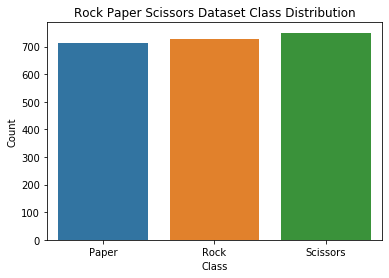

In [115]:
all_classes = train_classes + test_classes + val_classes
all_classes_df = pd.DataFrame(all_classes, columns=['Class'])
fig, ax = plt.subplots()
sns.countplot(x='Class', data=all_classes_df, ax=ax)
ax.set_title('Rock Paper Scissors Dataset Class Distribution')
ax.set_ylabel('Count')
ax.set_xticklabels(['Paper', 'Rock', 'Scissors'])

# Model Data

Build baseline dummy classifier model

In [119]:
x_train_dummy = [0]*len(train_classes)
y_train_dummy = train_classes
dc = DummyClassifier(strategy='stratified', random_state=84)
dc.fit(x_train_dummy, y_train_dummy)
y_val_pred_dc = dc.predict([0]*len(val_classes))
print('Val Accuracy Score:', accuracy_score(val_classes, y_val_pred_dc))

Val Accuracy Score: 0.3318077803203661


Build CNN

In [178]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(300 ,200,  3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.SpatialDropout2D(0.05))

model.add(layers.Conv2D(32, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.SpatialDropout2D(0.05))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

Fit cnn model

In [179]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
history = model.fit(train_images,
                    train_labels,
                    epochs=20,
                    batch_size=32,
                    validation_data=(test_images, test_labels),
                    callbacks=[es])

Epoch 1/20
44/44 [==============================] - 221s 5s/step - loss: 30.0438 - acc: 0.4432 - val_loss: 0.8840 - val_acc: 0.5767
Epoch 2/20
44/44 [==============================] - 153s 3s/step - loss: 0.6775 - acc: 0.7441 - val_loss: 0.3826 - val_acc: 0.8580
Epoch 3/20
44/44 [==============================] - 139s 3s/step - loss: 0.3623 - acc: 0.8792 - val_loss: 0.2786 - val_acc: 0.9119
Epoch 4/20
44/44 [==============================] - 132s 3s/step - loss: 0.2288 - acc: 0.9192 - val_loss: 0.2633 - val_acc: 0.9091
Epoch 5/20
44/44 [==============================] - 137s 3s/step - loss: 0.1688 - acc: 0.9450 - val_loss: 0.1780 - val_acc: 0.9403
Epoch 6/20
44/44 [==============================] - 139s 3s/step - loss: 0.1084 - acc: 0.9628 - val_loss: 0.1945 - val_acc: 0.9403
Epoch 7/20
44/44 [==============================] - 148s 3s/step - loss: 0.0735 - acc: 0.9764 - val_loss: 0.2091 - val_acc: 0.9403
Epoch 00007: early stopping


Evaluate CNN model

In [180]:
y_val_pred_nn = model.predict(val_images)
print('Val Accuracy Score:', accuracy_score(np.argmax(val_labels, axis=1), np.argmax(y_val_pred_nn, axis=1)))

Val Accuracy Score: 0.9450800915331807


Build CNN confusion matrix

[Text(0, 0.5, 'Paper'), Text(0, 1.5, 'Rock'), Text(0, 2.5, 'Scissors')]

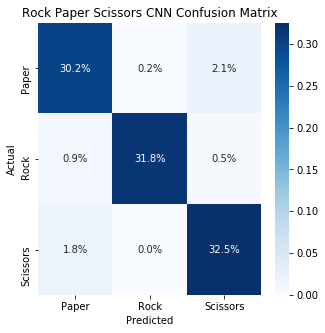

In [184]:
cm = confusion_matrix(np.argmax(val_labels, axis=1), np.argmax(y_val_pred_nn, axis=1))
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(cm/np.sum(cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('Rock Paper Scissors CNN Confusion Matrix')
matrix.set_xlabel('Predicted')
matrix.set_xticklabels(['Paper','Rock', 'Scissors'])
matrix.set_ylabel('Actual')
matrix.set_yticklabels(['Paper','Rock', 'Scissors'])